#**과제: 차원 축소 실습 및 시각화**



###**차원축소 실습**
1. 코드의 과정을 이해하고 주석 및 빈칸을 채워주세요
2. 최적의 주성분 또는 latent space를 정해서 차원축소를 진행하고 그 이유를 서술해주세요


PCA

원하는 분산 설명 비율을 정하고 시각화를 진행해 필요한 주성분 개수를 정해봅시다!

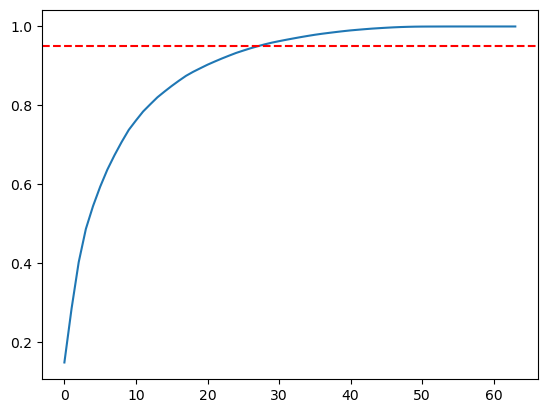

In [11]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

# 숫자 데이터셋 로드
digits = load_digits()
X = digits.data
y = digits.target

##1. 평균을 기준으로 데이터를 중장 정렬 (Mean Centering)
X_mean=X-np.mean(X,axis=0)

##2. SVD를 사용하여 주성분 분석 수행
# U: 좌직교 행렬, S: 특이값 벡터, Vt: 우직교 행렬 (전치) 
U,S,Vt=np.linalg.svd(X_mean)

##3. 주성분 벡터를 추출
principle_components=Vt.T

##4. 설명된 분산 비율 계산
# 각 특이값(S)의 제곱을 샘플개수 - 1로 나누어 분산 계산
explained_variance = (S ** 2) / (X.shape[0] - 1)
# 전체 분산에서 각 주성분이 차지하는 비율 계산
explained_variance_ratio = explained_variance / np.sum(explained_variance)
# 누적 분산 비율 계산
cumsum = np.cumsum(explained_variance_ratio)

# 누적 분산 비율을 시각화
plt.plot(cumsum)

##5.원하는 분산 설명 비율을 y의 값으로 작성해주세요
plt.axhline(y=0.95, color="r", linestyle="--", label="Threshold")


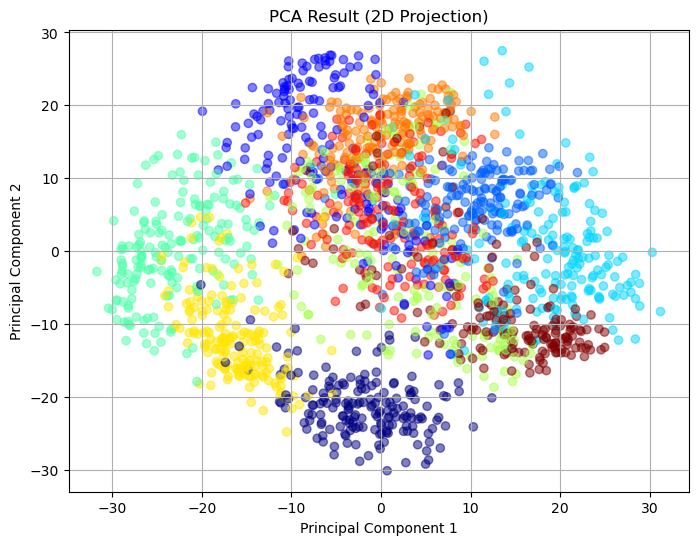

In [19]:
## 6. 분산 설명 비율을 만족하는 주성분 개수까지 eigen vector를 잘라봅시다
# 누적 분산 설명 비율(cumsum)에서 원하는 임계값(예: 95%)을 초과하는 최소 주성분 개수 찾기
num_components = np.argmax(cumsum >= 0.95) + 1 
principal_components = Vt[:num_components].T

## 7. 원본 데이터를 선택한 주성분 공간으로 투영하여 차원 축소 수행
X_pca = np.dot(X_mean, principal_components)

## 8. 2차원 시각화이지만, 원하신다면 변형하셔도 됩니다.
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="jet", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2") 
plt.title("PCA Result (2D Projection)") 
plt.grid(True)
plt.show()


문제. PCA에서는 어떤 주성분을 사용하셨나요? 그리고 그 이유는 뭔가요?

답. cumsum >= 0.95 조건을 만족하는 최소한의 주성분 개수를 찾았다. 또한 np.argmax()를 사용하여 누적 분산 설명 비율이 95%이상이 되는 가장 작은 인덱스를 반환했다. 원본 데이터는 64(8*8)차원이며, 고차원 데이터를 그대로 사용하면 계산 비용이 커지고 과적합 위험이 증가하여, 95% 이상의 분산을 유지하면서도 차원을 줄일 수 있는 최소 개수의 주성분을 선택하였다. 

LDA

선택된 최적의 n_components: 8


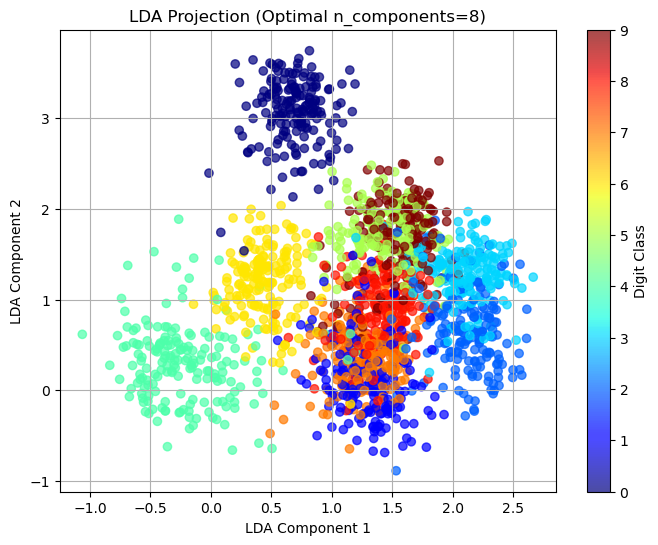

In [25]:
##1. X의 평균을 빼서 정규화 (각 특성의 평균이 0이 되도록 조정)
X_scaled = X-np.mean(X)

##2. 클래스별 평균 벡터 계산
class_labels = np.unique(y)
mean_vectors = [np.mean(X_scaled[y == label], axis=0) for label in class_labels]
mean_vectors = np.array(mean_vectors)

##3. 클래스 내 산포 행렬 S_W 계산 (각 클래스 내부의 분산을 합산)
S_W = np.zeros((X.shape[1], X.shape[1]))
for label, mean_vec in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((X.shape[1], X.shape[1]))
    for row in X_scaled[y == label]:
        row = row.reshape(-1, 1)
        mean_vec = mean_vec.reshape(-1, 1)
        class_scatter += (row - mean_vec) @ (row - mean_vec).T
    S_W += class_scatter

##4. 클래스 간 산포 행렬 S_B 계산 (클래스별 평균 벡터와 전체 평균 비교)
overall_mean = np.mean(X_scaled, axis=0).reshape(-1, 1)
S_B = np.zeros((X.shape[1], X.shape[1]))
for label, mean_vec in zip(class_labels, mean_vectors):
    mean_vec = mean_vec.reshape(-1, 1)
    n = X_scaled[y == label].shape[0]
    S_B += n * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T

##5. S_W의 역핵렬을 구한 뒤, S_B와 곱하여 변환 행렬 M 계산
U, S, Vt = np.linalg.svd(S_W)
S_inv = np.diag(1 / S)
S_W_inv = Vt.T @ S_inv @ U.T

M = S_W_inv @ S_B
eigenvalues, eigenvectors = np.linalg.eig(M)


idx = np.argsort(-eigenvalues.real)
eigenvalues = eigenvalues[idx].real
eigenvectors = eigenvectors[:, idx].real

##6. 전체 분산에서 각 고유값이 차지하는 비율 계산
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

##7.원하는 분산 설명 비율을 cumulative_variance의 조건식에 작성해주세요
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"선택된 최적의 n_components: {n_components}")

##6.분산 설명 비율을 만족하는 n_components까지 eigenvector를 자를 수 있도록 빈칸에 알맞게 작성해주세요
W_lda = eigenvectors[:, :n_components]
X_lda = X_scaled @ W_lda


plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Digit Class")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title(f"LDA Projection (Optimal n_components={n_components})")
plt.grid()
plt.show()

Autoencoder

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset


##1. 데이터 정규화 및 Pytorch 텐서 변환
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)


dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

##2. 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()

        # 인코더: 입력 데이터를 압축하여 잠재 공간으로 변환 64 -> 32 -> 16 -> 잠재 공간
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

        #디코더: 잠재 공간의 데이터를 다시 원래 차원으로 복원 잠재 공간 -> 16 0> 32 -> 64 차원
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

##3. 학습을 위한 모델 설정 및 손실 함수, 최적화 기법 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

문제. LDA에서는 어떤 주성분을 사용하셨나요? 그리고 그 이유는 뭔가요?

답. 코드에서 "eigenvectors[:, :n_components]"를 선택하여 사용했으며, 이는 가장 큰 고유값을 가진 고유벡터들을 의미한다. 즉, 클래스 간 분산을 극대화하는 방향을 나타내는 주성분들을 선택했다. LDA의 목적은 클래스를 잘 분리할 수 있는 방법을 찾는 것이다. 가장 큰 고유값을 가지는 고유벡터들은 클래스 간 분산을 가장 많이 증가시키는 방향으 나타내므로, 이 방향을 따라 데이터를 투영하면 클래스 간 분리가 극대화 된다.

Autoencoder-분류기를 통한 성능 평가

Latent Dim: 3, Accuracy: 0.4422
Latent Dim: 4, Accuracy: 0.8200
Latent Dim: 5, Accuracy: 0.8600
Latent Dim: 6, Accuracy: 0.7433


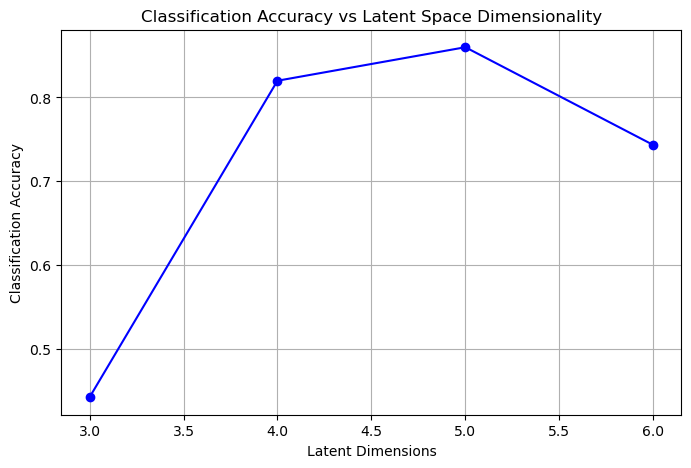

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##원하는 latent_dims로 실험해보세요!!
latent_dims = [3,4,5,6]  ##eg. latent_dims[3,4]
accuracies = []

##learning rate 조절하셔도 됩니다
for dim in latent_dims:
    model = Autoencoder(latent_dim=dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    accuracy=0

##epoch 조절하셔도 됩니다
    for i in range(0,10):
      num_epochs = 20
      for epoch in range(num_epochs):
          for X_batch, _ in data_loader:
              X_batch = X_batch.to(device)
              recon, _ = model(X_batch)
              loss = criterion(recon, X_batch)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


      X_encoded = []
      y_labels = []
      with torch.no_grad():
          for X_batch, y_batch in data_loader:
              X_batch = X_batch.to(device)
              _, z = model(X_batch)
              X_encoded.append(z.cpu().numpy())
              y_labels.append(y_batch.numpy())

      X_encoded = np.vstack(X_encoded)
      y_labels = np.hstack(y_labels)

      ##분류기로 성능 평가를 진행해보겠습니다
      X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_labels, test_size=0.2, random_state=42)
      clf = RandomForestClassifier(n_estimators=100, random_state=42)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      accuracy += accuracy_score(y_test, y_pred)

    accuracies.append(accuracy/10)

    print(f"Latent Dim: {dim}, Accuracy: {accuracy/10:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(latent_dims, accuracies, marker="o", linestyle="-", color="b")
plt.xlabel("Latent Dimensions")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs Latent Space Dimensionality")
plt.grid()
plt.show()

Autoencoder 결과 시각화

원하는 latent space를 지정해서 시각화를 진행해봅시다

Epoch [1/20], Loss: 29.8526
Epoch [2/20], Loss: 27.5871
Epoch [3/20], Loss: 27.3050
Epoch [4/20], Loss: 27.4792
Epoch [5/20], Loss: 27.4275
Epoch [6/20], Loss: 27.1874
Epoch [7/20], Loss: 26.9862
Epoch [8/20], Loss: 26.4436
Epoch [9/20], Loss: 26.6630
Epoch [10/20], Loss: 25.9993
Epoch [11/20], Loss: 25.6571
Epoch [12/20], Loss: 25.0132
Epoch [13/20], Loss: 24.9744
Epoch [14/20], Loss: 24.2918
Epoch [15/20], Loss: 23.9407
Epoch [16/20], Loss: 23.7369
Epoch [17/20], Loss: 23.5645
Epoch [18/20], Loss: 23.6993
Epoch [19/20], Loss: 24.7104
Epoch [20/20], Loss: 23.3954


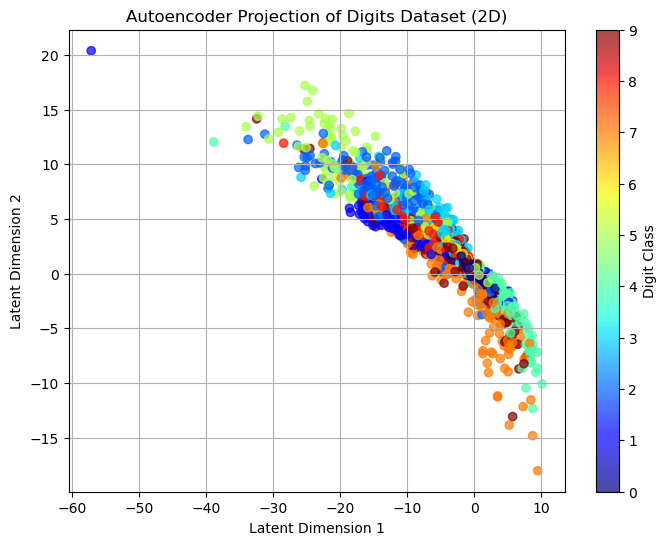

In [33]:
model = Autoencoder(latent_dim=6).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, _ in data_loader:
        X_batch = X_batch.to(device)
        recon, _ = model(X_batch)
        loss = criterion(recon, X_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

X_encoded = []
y_labels = []

with torch.no_grad():
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        _, z = model(X_batch)
        X_encoded.append(z.cpu().numpy())
        y_labels.append(y_batch.numpy())

X_encoded = np.vstack(X_encoded)
y_labels = np.hstack(y_labels)


plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y_labels, cmap="jet", alpha=0.7)
plt.colorbar(label="Digit Class")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Autoencoder Projection of Digits Dataset (2D)")
plt.grid()
plt.show()

문제. Autoencoder에서는 어떤 latent space를 사용하셨나요? 그리고 그 이유는 뭔가요?

답.

###**T-SNE를 이용한 시각화**
PCA와 t-SNE의 차원 축소 결과를 시각화하고 비교해보세요. 답 작성란은 아래에 있습니다:)

In [35]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd


data_digit= datasets.load_digits()

df_digit = pd.DataFrame(data = data_digit['data'], columns=data_digit['feature_names'])
label_digit = data_digit['target']

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2)

df_digit_tsne=pd.DataFrame(data=tsne.fit_transform(df_digit),columns=["col1","col2"])
df_digit_tsne["label"]=label_digit

scaler=StandardScaler()
df_digit_scaled=pd.DataFrame(data=scaler.fit_transform(df_digit))

pca=PCA(n_components=2)
df_digit_pca=pd.DataFrame(data=pca.fit_transform(df_digit_scaled),columns=["col1","col2"])


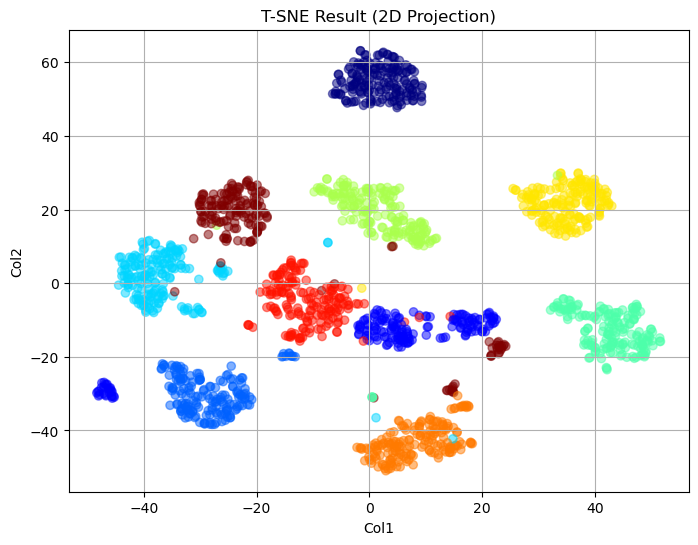

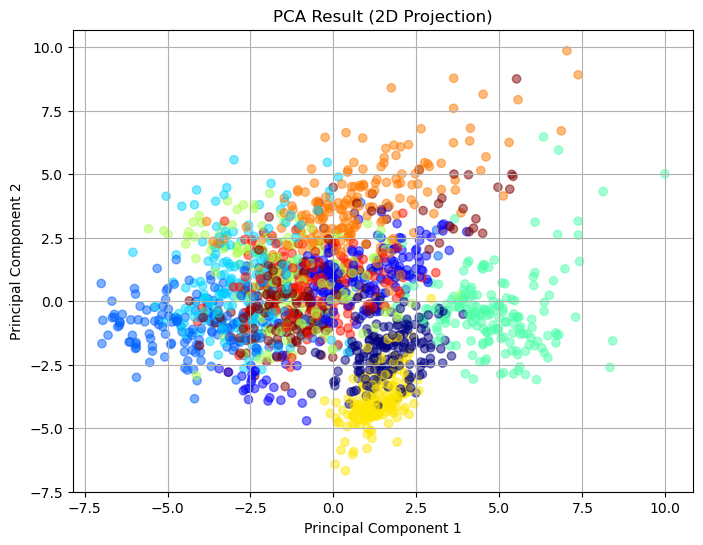

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(df_digit_tsne['col1'], df_digit_tsne['col2'],  c=label_digit, cmap="jet", alpha=0.5)
plt.xlabel("Col1")
plt.ylabel("Col2")
plt.title("T-SNE Result (2D Projection)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_digit_pca['col1'], df_digit_pca['col2'],  c=label_digit, cmap="jet", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Result (2D Projection)")
plt.grid(True)
plt.show()

문제. 어떤 차원축소 기법이 더 좋은 시각화 결과를 냈는지, 이 이유가 무엇인지 서술하세요

답: